# VGGVox

In [1]:
import pandas as pd
import os
import numpy as np
import re

In [2]:
if not os.path.exists('VGGVox-PyTorch'):
    ! git clone https://github.com/Derpimort/VGGVox-PyTorch.git
    if not os.path.exists('VGGVox-PyTorch/dataset'):
        os.system('mkdir dataset')
    os.system('rm -r VGGVox-PyTorch/data')
    os.system('cp -r dataset/ VGGVox-PyTorch/dataset/' )
    os.chdir('VGGVox-PyTorch')
    ! pip install -r requirements.txt
    
else:
    if not os.path.exists('VGGVox-PyTorch/dataset'):
        os.system('mkdir dataset')
    os.system('rm -r VGGVox-PyTorch/data')
    os.system(' cp -r dataset/ VGGVox-PyTorch/dataset/' )
    os.chdir('VGGVox-PyTorch')
    ! pip install -r requirements.txt

rm: VGGVox-PyTorch/data: No such file or directory


  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [3]:
import torch
from torch.utils.data import Subset, Dataset, DataLoader
from tqdm.auto import tqdm
from vggm import VGGM
import argparse
from train import AudioDataset, accuracy, ppdf, LOCAL_DATA_DIR, MODEL_DIR

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import time
%matplotlib inline

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=VGGM(1251)
model.load_state_dict(torch.load(MODEL_DIR+"VGGM300_BEST_140_81.99.pth", map_location=device))
model.to(device)
model.eval()

### This is to extract an activation from one layer ...
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [5]:
DATA_DIR = '/Users/isabel.rodriguez/Desktop/Isa/MUIT - Machine Learning/DLAS/project/VGGVox-PyTorch'

df = pd.read_csv('./dataset/labels.csv')

Datasets={"test":AudioDataset(df, DATA_DIR, is_train=False)}

Dataloaders={i:DataLoader(Datasets[i], batch_size=1, shuffle=True, num_workers=2) for i in Datasets}

embedding_arr = []

for audio, labels in Dataloaders['test']:
        audio = audio.to(device)
        labels = labels.to(device)
        model.classifier.fc7.register_forward_hook(get_activation('fc7'))
        outputs = model(audio)

        embedding_arr.append(activation['fc7'].cpu().numpy().reshape(-1))

df['Embeddings'] = pd.Series(embedding_arr)

In [6]:
df

,Path,Filename,Label,Embeddings
0,dataset/AVPEPUDEAC0001_pataka.wav,AVPEPUDEAC0001_pataka.wav,0,"[-2.2574333e-11, -4.0789344e-11, -3.784933e-10..."
1,dataset/AVPEPUDEAC0003_pataka.wav,AVPEPUDEAC0003_pataka.wav,0,"[-2.5480656e-11, -4.7625816e-11, -4.2545373e-1..."
2,dataset/AVPEPUDEAC0004_pataka.wav,AVPEPUDEAC0004_pataka.wav,0,"[-2.7231689e-11, -5.0361847e-11, -4.7508525e-1..."
3,dataset/AVPEPUDEAC0005_pataka.wav,AVPEPUDEAC0005_pataka.wav,0,"[-2.9902917e-11, -5.3089137e-11, -4.4072018e-1..."
4,dataset/AVPEPUDEAC0006_pataka.wav,AVPEPUDEAC0006_pataka.wav,0,"[-2.3982026e-11, -4.525018e-11, -4.2867246e-10..."
...,...,...,...,...
95,dataset/AVPEPUDEA0055_pataka.wav,AVPEPUDEA0055_pataka.wav,1,"[-2.597591e-11, -4.8046504e-11, -4.096229e-10,..."
96,dataset/AVPEPUDEA0056_pataka.wav,AVPEPUDEA0056_pataka.wav,1,"[-2.7596307e-11, -5.3557946e-11, -4.765024e-10..."
97,dataset/AVPEPUDEA0057_pataka.wav,AVPEPUDEA0057_pataka.wav,1,"[-2.212378e-11, -4.1993617e-11, -4.2437104e-10..."
98,dataset/AVPEPUDEA0058_pataka.wav,AVPEPUDEA0058_pataka.wav,1,"[-2.771281e-11, -5.5143216e-11, -5.077024e-10,..."


In [7]:
df["Pred_Label"] = 0

speaker_t1 = 0
speaker_t2 = 1
embedding_1 = df[df['Label']== speaker_t1].iloc[0]['Embeddings']
embedding_2 = df[df['Label']== speaker_t2].iloc[0]['Embeddings']

similarity = cosine_similarity(embedding_1.reshape(1,-1), embedding_2.reshape(1,-1))
cosine_distance = 1 - similarity

print('Cosine similarity: ', similarity, ' cosine distance: ', cosine_distance)


print('\n\n-----------------Speaker: ', speaker_t1)
print(df[df['Label']== speaker_t1].iloc[0],'\n')


print('-----------------Speaker: ', speaker_t2)
print(df[df['Label']== speaker_t2].iloc[0])


Cosine similarity:  [[0.84896415]]  cosine distance:  [[0.15103585]]


-----------------Speaker:  0
Path                          dataset/AVPEPUDEAC0001_pataka.wav
Filename                              AVPEPUDEAC0001_pataka.wav
Label                                                         0
Embeddings    [-2.2574333e-11, -4.0789344e-11, -3.784933e-10...
Pred_Label                                                    0
Name: 0, dtype: object 

-----------------Speaker:  1
Path                           dataset/AVPEPUDEA0001_petaka.wav
Filename                               AVPEPUDEA0001_petaka.wav
Label                                                         1
Embeddings    [-3.1678073e-11, -5.4082627e-11, -4.94649e-10,...
Pred_Label                                                    0
Name: 50, dtype: object


In [8]:
for i in range (0, len(df['Embeddings'])):
    if i!=0 and i !=50:
        similarity_sp1 = cosine_similarity(embedding_1.reshape(1,-1), df['Embeddings'][i].reshape(1,-1))
        cosine_distance_sp1 = 1 - similarity_sp1
        similarity_sp2 = cosine_similarity(embedding_2.reshape(1,-1), df['Embeddings'][i].reshape(1,-1))
        cosine_distance_sp2 = 1 - similarity_sp2

        print('Cosine similarity with speaker 1: ', similarity_sp1, ' cosine distance with speaker 1: ', cosine_distance_sp1)
        print('Cosine similarity with speaker 2: ', similarity_sp2, ' cosine distance with speaker 2: ', cosine_distance_sp2)
        
        if min(cosine_distance_sp1,cosine_distance_sp2) == cosine_distance_sp1:
            df['Pred_Label'][i] = 0
        elif min(cosine_distance_sp1,cosine_distance_sp2) == cosine_distance_sp2:
            df['Pred_Label'][i] = 1
        else:
            df['Pred_Label'][i] = np.nan
    else:
        df['Pred_Label'].iloc[0] = 0
        df['Pred_Label'].iloc[50] = 1


Cosine similarity with speaker 1:  [[0.831773]]  cosine distance with speaker 1:  [[0.16822702]]
Cosine similarity with speaker 2:  [[0.8771102]]  cosine distance with speaker 2:  [[0.12288982]]
Cosine similarity with speaker 1:  [[0.9000213]]  cosine distance with speaker 1:  [[0.09997869]]
Cosine similarity with speaker 2:  [[0.9129715]]  cosine distance with speaker 2:  [[0.0870285]]
Cosine similarity with speaker 1:  [[0.8946378]]  cosine distance with speaker 1:  [[0.10536218]]
Cosine similarity with speaker 2:  [[0.8330828]]  cosine distance with speaker 2:  [[0.1669172]]
Cosine similarity with speaker 1:  [[0.79728687]]  cosine distance with speaker 1:  [[0.20271313]]
Cosine similarity with speaker 2:  [[0.86538595]]  cosine distance with speaker 2:  [[0.13461405]]
Cosine similarity with speaker 1:  [[0.939069]]  cosine distance with speaker 1:  [[0.06093103]]
Cosine similarity with speaker 2:  [[0.85344774]]  cosine distance with speaker 2:  [[0.14655226]]
Cosine similarity wit

Cosine similarity with speaker 1:  [[0.8098749]]  cosine distance with speaker 1:  [[0.19012511]]
Cosine similarity with speaker 2:  [[0.84158283]]  cosine distance with speaker 2:  [[0.15841717]]
Cosine similarity with speaker 1:  [[0.91696]]  cosine distance with speaker 1:  [[0.08304]]
Cosine similarity with speaker 2:  [[0.87285054]]  cosine distance with speaker 2:  [[0.12714946]]
Cosine similarity with speaker 1:  [[0.8107393]]  cosine distance with speaker 1:  [[0.18926072]]
Cosine similarity with speaker 2:  [[0.8577539]]  cosine distance with speaker 2:  [[0.14224613]]
Cosine similarity with speaker 1:  [[0.8441647]]  cosine distance with speaker 1:  [[0.15583527]]
Cosine similarity with speaker 2:  [[0.8616675]]  cosine distance with speaker 2:  [[0.13833249]]
Cosine similarity with speaker 1:  [[0.84641516]]  cosine distance with speaker 1:  [[0.15358484]]
Cosine similarity with speaker 2:  [[0.8666973]]  cosine distance with speaker 2:  [[0.13330269]]


/Users/isabel.rodriguez/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/var/folders/tw/_h7yq1ks6m93h0ly9bzf7d9h0000gn/T/ipykernel_49393/3631717452.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pred_Label'][i] = 1
/var/folders/tw/_h7yq1ks6m93h0ly9bzf7d9h0000gn/T/ipykernel_49393/3631717452.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [9]:
df

,Path,Filename,Label,Embeddings,Pred_Label
0,dataset/AVPEPUDEAC0001_pataka.wav,AVPEPUDEAC0001_pataka.wav,0,"[-2.2574333e-11, -4.0789344e-11, -3.784933e-10...",0
1,dataset/AVPEPUDEAC0003_pataka.wav,AVPEPUDEAC0003_pataka.wav,0,"[-2.5480656e-11, -4.7625816e-11, -4.2545373e-1...",1
2,dataset/AVPEPUDEAC0004_pataka.wav,AVPEPUDEAC0004_pataka.wav,0,"[-2.7231689e-11, -5.0361847e-11, -4.7508525e-1...",1
3,dataset/AVPEPUDEAC0005_pataka.wav,AVPEPUDEAC0005_pataka.wav,0,"[-2.9902917e-11, -5.3089137e-11, -4.4072018e-1...",0
4,dataset/AVPEPUDEAC0006_pataka.wav,AVPEPUDEAC0006_pataka.wav,0,"[-2.3982026e-11, -4.525018e-11, -4.2867246e-10...",1
...,...,...,...,...,...
95,dataset/AVPEPUDEA0055_pataka.wav,AVPEPUDEA0055_pataka.wav,1,"[-2.597591e-11, -4.8046504e-11, -4.096229e-10,...",1
96,dataset/AVPEPUDEA0056_pataka.wav,AVPEPUDEA0056_pataka.wav,1,"[-2.7596307e-11, -5.3557946e-11, -4.765024e-10...",0
97,dataset/AVPEPUDEA0057_pataka.wav,AVPEPUDEA0057_pataka.wav,1,"[-2.212378e-11, -4.1993617e-11, -4.2437104e-10...",1
98,dataset/AVPEPUDEA0058_pataka.wav,AVPEPUDEA0058_pataka.wav,1,"[-2.771281e-11, -5.5143216e-11, -5.077024e-10,...",1


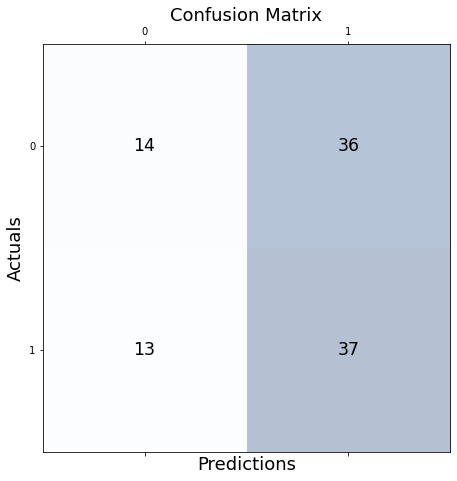

In [10]:
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=df['Label'], y_pred=df['Pred_Label'])
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [11]:
n_components = 100 #maximum number of components

X = np.stack(df['Embeddings'].values)

scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)

pca = PCA(n_components = n_components)

pca.fit(X_scaled)

PCA(n_components=100)

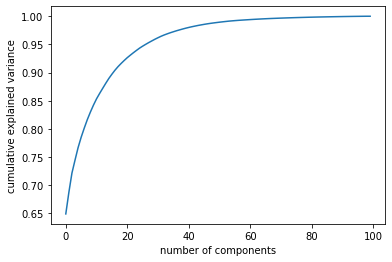

In [12]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

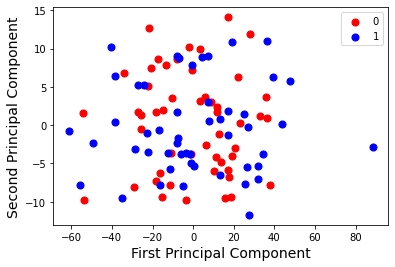

In [13]:
group = df['Label']
cdict = {0: 'red', 1: 'blue'}

Z1 = pca.transform(X_scaled)[:,0]
Z2 = pca.transform(X_scaled)[:,1]

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(Z1[ix], Z2[ix], c = cdict[g], label = g, s = 50)

plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
ax.legend()

In [14]:
time_start = time.time()

X_tsne = TSNE(random_state=123).fit_transform(X_scaled)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 0.2770686149597168 seconds


In [15]:
X_tsne.shape

(100, 2)

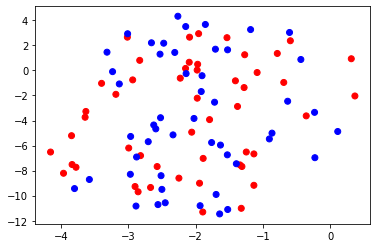

In [16]:
color = []
for label in df['Label']:
    if label == 0:
        color.append('red')
    elif label == 1:
        color.append('blue')

plt.scatter(X_tsne[:,0] ,X_tsne[:,1], c = color)